# Detection of Diabetic Retinopathy using Convolutional Neural Networks

## Exploracion de datos

### Carga de datos

Los datos se se han obtenido de Kaggle.com, en donde se proporciona un archivo `zip` con carpetas de imagenes y archivos `csv` en donde se muestra el nombre de la imagen asi como la etiqueta correpondiente al nivel de retinopatia diabetica a la que pertence.

Como primer paso relizamos el análisis del archivo `csv` con las librerias `pandas` y `numpy`.

* Data Science
* KDD process

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import sys

# Load data from csv file
df_labels = pd.read_csv('C:/Users/FINSUS-Admin/Documents/gblasd/DDRUCNN/data/trainLabels_cropped.csv', delimiter=',', header='infer', encoding='utf-8')

# Remove any rows with missing data
df_labels = df_labels.dropna(axis=0, how='any')

# Print the result out into this notebook
df_labels 


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
...,...,...
35103,44347_right,0
35104,44348_left,0
35105,44348_right,0
35106,44349_left,0


### Visualizacion de datos

Analizamos el numero de imagenes de cada clase, para un mejor analisis visualizamos la distribucion de datos en una grafica.

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

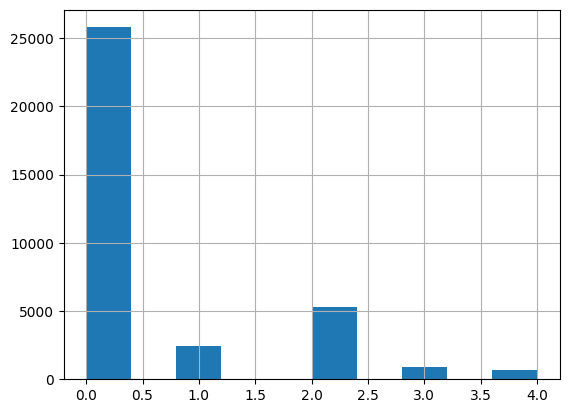

In [2]:
# Ensure plots are displayed inline in the notebook
%matplotlib inline

from matplotlib import pyplot as plt # showing and rendering figures 

# Display plot
df_labels['level'].hist()

# Number of images to each label
df_labels['level'].value_counts()


Como observamos en la grafica tenemos un total de `35108` imagenes en total, distribuidas en 5 clases.  

Además, de acuerdo con los datos debemos tener en cuenta lo siguiente:
* tenemos imagenes de ambos ojos por paciente, esto al mostrarse en las etiquetas si es una imagen de un ojo izquierdo o derecho.
* el archivo muestra las etiquetas de los ojo, pero debemos comprobar su existencia en el directorio, para ello debemos armar su direccion.

Posterior a ello, debemos relizar un balanceo de datos entre cada clase asi como una separacion en datos de entranamiento y datos de validacion para el modelo a entrenar. sin olvidar el preprocesamiento.

* Imbalanced Classification with Multiple Classes

In [3]:
from skimage.io import imread
from glob import glob

base_image_dir = os.path.join('C:\\Users\\FINSUS-Admin\\Documents\\gblasd\\DDRUCNN','data')
# print(base_image_dir)
retina_df = pd.read_csv(os.path.join(base_image_dir,'trainLabels_cropped.csv'))
# print(os.path.join(base_image_dir, 'trainLabels_cropped.csv'))

# Get number of patient
retina_df['PatientId'] =  retina_df['image'].map(lambda x: x.split('_')[0])
# get path of the image
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, 'resized_train_cropped', '{}.jpeg'.format(x)))
# We check if the image exists in the directory
retina_df['exists'] = retina_df['path'].map(os.path.exists)

print(retina_df['exists'].sum(), ' images found of ', retina_df.shape[0], ' total')

# 0 if it is right eye, 1 if it is opposite
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1] == 'left' else 0)

retina_df

35108  images found of  35108  total


,image,level,PatientId,path,exists,eye
0,10_left,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
1,10_right,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
2,13_left,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
3,13_right,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
4,15_left,1,15,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
...,...,...,...,...,...,...
35103,44347_right,0,44347,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
35104,44348_left,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1
35105,44348_right,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0
35106,44349_left,0,44349,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1


In [4]:
from keras.utils.np_utils import to_categorical # Converts a class vector (integers) to binary class matrix.

retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
retina_df.dropna(inplace=True) # Remove missing values.
retina_df = retina_df[retina_df['exists']] # add columns
retina_df.sample(5) # Return a random sample of items from an axis of object.

,image,level,PatientId,path,exists,eye,level_cat
24137,30522_right,0,30522,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
20441,25801_right,0,25801,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
16307,20455_right,0,20455,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
16141,20236_right,1,20236,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[0.0, 1.0, 0.0, 0.0, 0.0]"
29689,37588_right,2,37588,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"


### Examinamos la distribucion de la severidad en los ojos

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

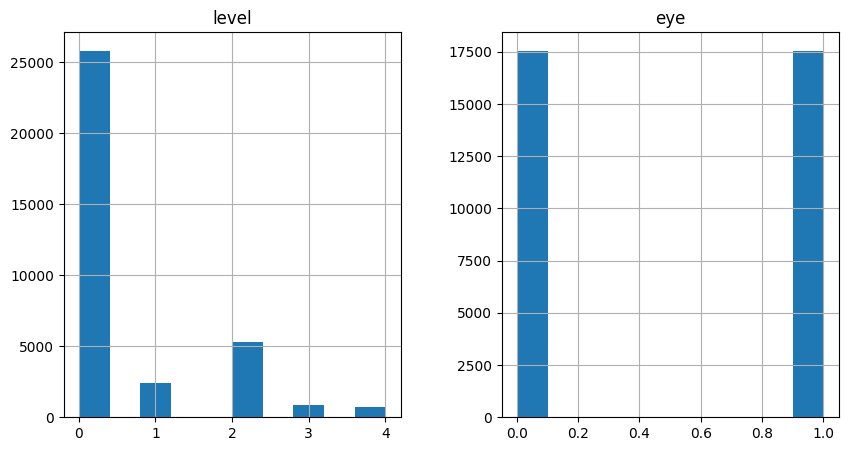

In [5]:
retina_df[['level', 'eye']].hist(figsize=(10,5))

Como obseramos en la distribucion original, tenemos una clase `0` en la cual se tiene el `73.49%` del total de imagenes, lo cual es enecesario realizar un balanceo de clases, por ello se planea realizar un submestreo `under-sampling` para eliminar elementos de la clase mayoritaria, posterior a ello realizar un submuestreo `over-sampling` para agregar elementos de las clases minoritarias.

### Balanceamos la distribucion del data set

In [6]:
import os
import imblearn
from imblearn.pipeline import Pipeline
# from fastai.callback.tracker import SaveModelCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import *


In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input


In [8]:
sampler = RandomUnderSampler()
images = list(retina_df.image)
labels = list(retina_df.level)

images, labels = sampler.fit_resample(np.array(images).reshape(-1,1), labels)

images = images.reshape(-1)
data = pd.DataFrame(data={'image':images, 'level':labels})

data.shape

(3540, 2)

In [16]:
images = images.reshape(-1)
data = pd.DataFrame(data={'image':images, 'level':labels})

data.shape

(3540, 2)

<Axes: >

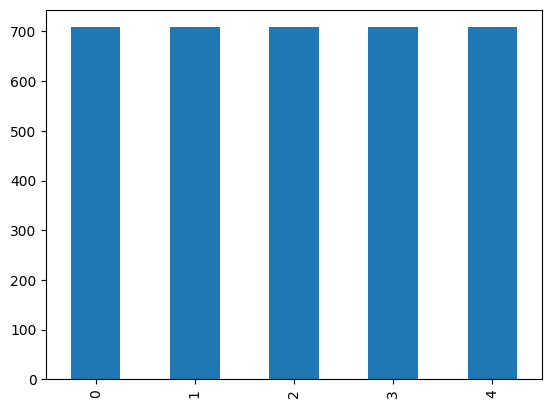

In [17]:
data.level.value_counts().plot(kind="bar")

In [18]:
data

,image,level
0,8089_right,0
1,1997_left,0
2,14443_left,0
3,40890_right,0
4,37564_left,0
...,...,...
3535,44100_left,4
3536,44247_left,4
3537,44247_right,4
3538,44249_left,4


In [24]:
data_completed = pd.merge(data, retina_df, how='left', on='image')

In [26]:
retina_df

,image,level,PatientId,path,exists,eye,level_cat
0,10_left,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,10_right,0,10,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,13_left,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,13_right,0,13,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,15_left,1,15,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
35103,44347_right,0,44347,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
35104,44348_left,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
35105,44348_right,0,44348,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
35106,44349_left,0,44349,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [25]:
data_completed

,image,level_x,level_y,PatientId,path,exists,eye,level_cat
0,8089_right,0,0,8089,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,1997_left,0,0,1997,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,14443_left,0,0,14443,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,40890_right,0,0,40890,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,37564_left,0,0,37564,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
3535,44100_left,4,4,44100,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[0.0, 0.0, 0.0, 0.0, 1.0]"
3536,44247_left,4,4,44247,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[0.0, 0.0, 0.0, 0.0, 1.0]"
3537,44247_right,4,4,44247,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,0,"[0.0, 0.0, 0.0, 0.0, 1.0]"
3538,44249_left,4,4,44249,C:\Users\FINSUS-Admin\Documents\gblasd\DDRUCNN...,True,1,"[0.0, 0.0, 0.0, 0.0, 1.0]"


verificamos la distribucion de cada una de las clases con respecto al total de las imagenes

In [28]:
valid_list = [i for i in data_completed['level_x'].value_counts()]

dist_1 = [str(round(x*100/sum(valid_list), 2))+'%' for x in valid_list]

for i in range(len(valid_list)): print("{:>8} -> {:>6}".format(valid_list[i], dist_1[i])) 


     708 ->  20.0%
     708 ->  20.0%
     708 ->  20.0%
     708 ->  20.0%
     708 ->  20.0%


verificamos que las columnas `level_x`y `level_y` sean iguales

In [31]:
print(data_completed['level_x'].equals(data_completed['level_y']))

True


Balanceo de datos con Naive random over-sampling -> https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler

Haré que el resultado sea una X mayúscula , porque será una matriz 2D, y una letra mayúscula es la convención de nomenclatura estadística para una matriz 2D (también conocida como matriz ).

### Separamos datos en bloque de entrenamiento y validación


In [32]:
# train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(700, replace=True)).reset_index(drop=True)
# print('New Data Size: ', train_df.shape[0], ' Old size: ', raw_train_df.shape[0])
# train_df[['level', 'eye']].hist(figsize=(10,5))


# rr_df = retina_df[['PatientId', 'level']].drop_duplicates() # Return DataFrame with duplicate rows removed.

# Split arrays or matrices into random train and test subsets.
train_ids, valid_ids = train_test_split(data_completed['image'],         # arrays
                                        test_size=0.20,             # test_size
                                        train_size=0.80,            # train_size
                                        random_state=2018,          # check (Controls the shuffling applied to the data before applying the split. )
                                        stratify=data_completed['level_x'])    # labels of class

raw_train_df = retina_df[retina_df['image'].isin(train_ids)]    # Whether each element in the DataFrame is contained in values.
valid_df = retina_df[retina_df['image'].isin(valid_ids)]

print('train', raw_train_df.shape[0], ' validation ', valid_df.shape[0])

train 2832  validation  708


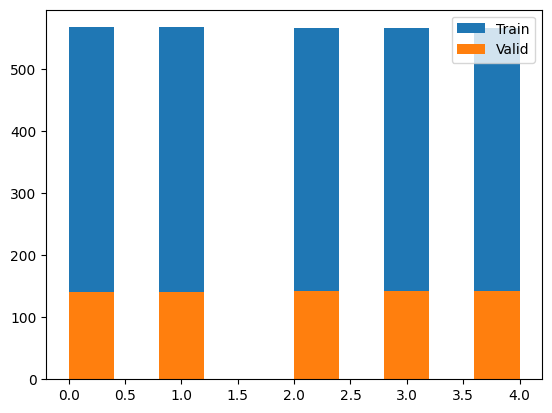

In [33]:
plt.hist(raw_train_df[['level']], label='Train')
plt.hist(valid_df[['level']], label='Valid')
plt.legend(loc='upper right')

Distribucion del set de entrenamiento en cada una de sus clases

In [34]:
# get number of clases
train_list = [i for i in raw_train_df['level'].value_counts()]

dist = [str(round(x*100/sum(train_list), 2))+'%' for x in train_list]

for i in range(len(train_list)): print("{:>8} -> {:>6}".format(train_list[i], dist[i])) 



     567 -> 20.02%
     567 -> 20.02%
     566 -> 19.99%
     566 -> 19.99%
     566 -> 19.99%


Distribución del set de validacion entre cada una de las clases

In [35]:
valid_list = [i for i in valid_df['level'].value_counts()]

dist_1 = [str(round(x*100/sum(valid_list), 2))+'%' for x in valid_list]

for i in range(len(valid_list)): print("{:>8} -> {:>6}".format(valid_list[i], dist_1[i])) 


     142 -> 20.06%
     142 -> 20.06%
     142 -> 20.06%
     141 -> 19.92%
     141 -> 19.92%


como podemos observar las clases estan balanceadas

problemas para pasar de `pandas.core.frame.DataFrame` a `pandas.core.series.Series`


### Previsualizacion de las imagenes

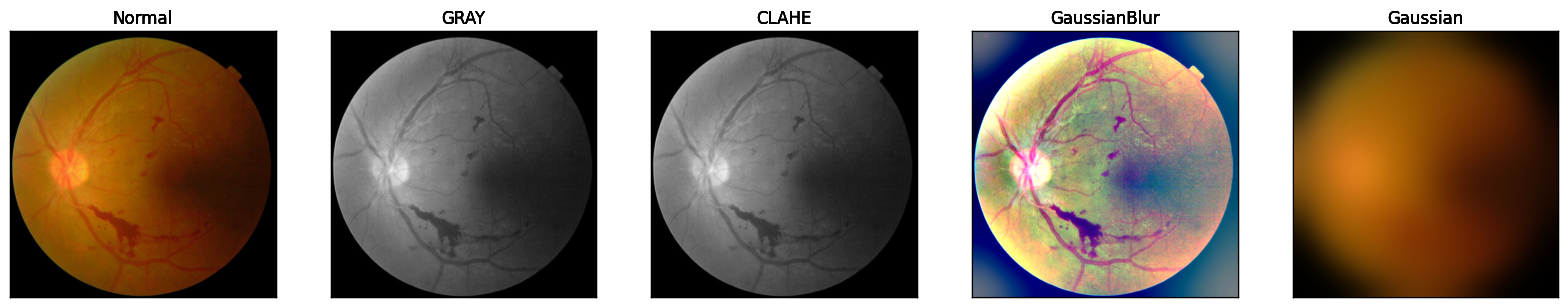

In [38]:
import cv2 

NUM_SAMP = 5
SIZE_IMG = 500

fig = plt.figure(figsize=(20,20))

for class_id in sorted(data_completed['level_x'].sort_values().unique()):           # by each class
    for i in range(5):
        image = cv2.imread(data_completed['path'][3535])
        image = cv2.resize(image, (SIZE_IMG, SIZE_IMG))
        if i == 0:
            ax = fig.add_subplot(5, NUM_SAMP, 1, xticks=[], yticks=[])
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)   ################# https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
            plt.imshow(image)
            ax.set_title('Normal')
        elif i == 1:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            ax = fig.add_subplot(5, NUM_SAMP, 2, xticks=[], yticks=[])
            plt.imshow(image, cmap='gray')
            ax.set_title('GRAY')
        elif i == 2:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            ax = fig.add_subplot(5, NUM_SAMP, 3, xticks=[], yticks=[])
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            var = clahe.apply(image)
            plt.imshow(image, cmap='gray')
            ax.set_title('CLAHE')
        elif i == 3:
            ax = fig.add_subplot(5, NUM_SAMP, 4, xticks=[], yticks=[])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),SIZE_IMG/10),-4,128)
            image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),SIZE_IMG/10),-4,128)
            plt.imshow(image, cmap='gray')
            ax.set_title('GaussianBlur')
        else:
            ax = fig.add_subplot(5, NUM_SAMP, 5, xticks=[], yticks=[])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.GaussianBlur(image,(0,0),30)
            plt.imshow(image, cmap='gray')
            ax.set_title('Gaussian')
        # else:
        #     ax = fig.add_subplot(5, NUM_SAMP, 5, xticks=[], yticks=[])
        #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #     equ = cv2.equalizeHist(image)
        #     res = np.hstack((image,equ)) #stacking images side-by-side
        #     plt.imshow(image, cmap='gray')
        #     ax.set_title('equalizeHist')

        # ax.set_title('Lvl: %d -  %s' % (train_df['level'][0], train_df['image'][0]))
        # class 0 ->    0,   1,   2,   3,   4
        # class 1 -> 2157,2618,1794,1876,1717
        # class 2 -> 3575,2961,3641,3579,3554
        # class 3 -> 5384,4982,5369,4806,4926
        # class 4 -> 6483,6168,6922,6858,6649
        

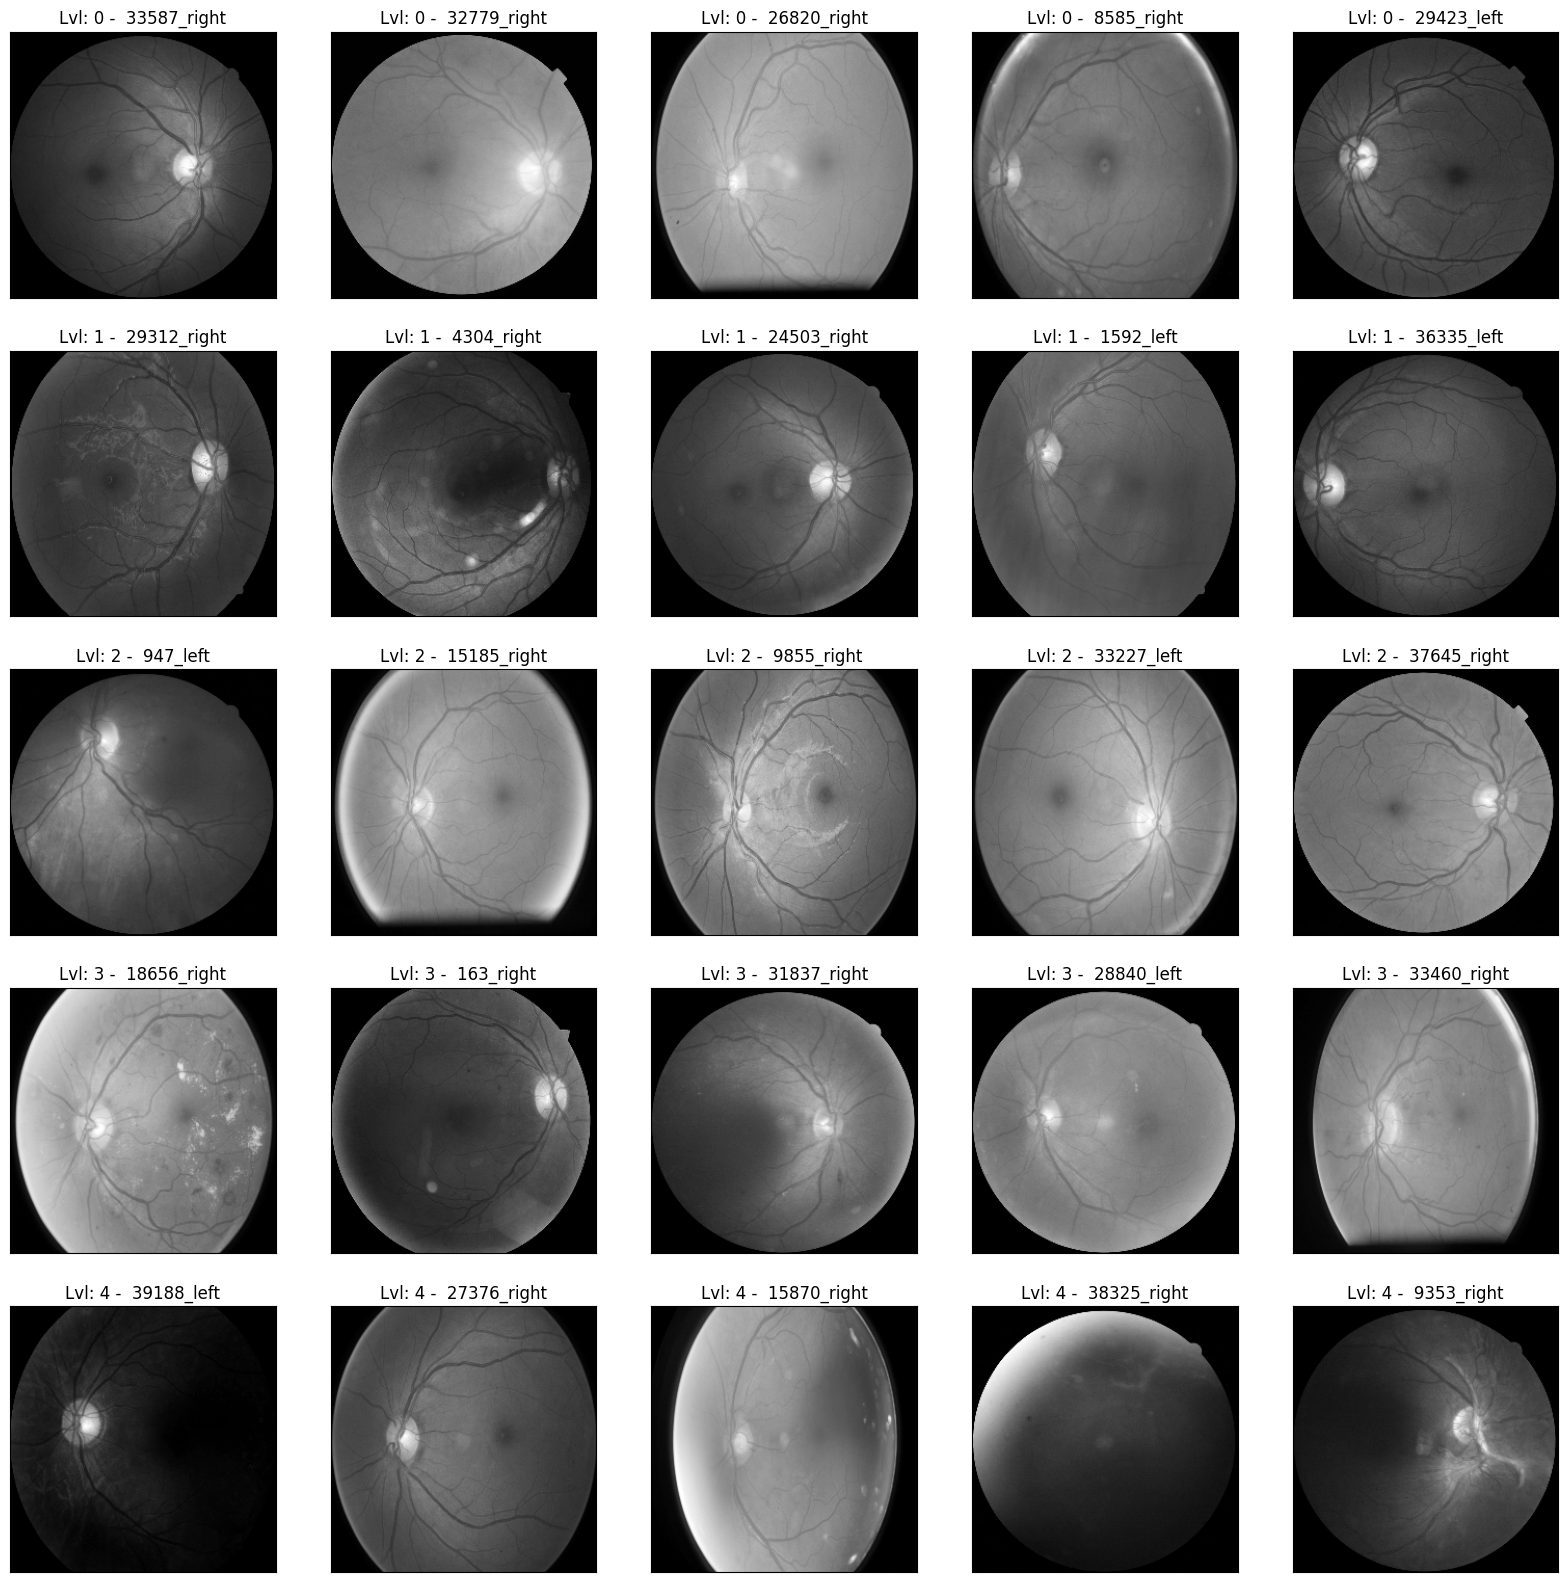

In [41]:
import cv2

NUM_SAMP = 5
SIZE_IMG = 256

fig = plt.figure(figsize=(20,20))

for class_id in sorted(data_completed['level_x'].sort_values().unique()):           # by each class
    for i,(idx, row) in enumerate(data_completed[data_completed['level_x'] == class_id].sample(NUM_SAMP).iterrows()): # get two samples img
        # print(i, idx, row['level'])
        # print(class_id * NUM_SAMP + i + 1)
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        image = cv2.imread(row['path'])
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, (SIZE_IMG, SIZE_IMG))

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        var = clahe.apply(image)

        # image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , SIZE_IMG/10) ,-4 ,128) # the trick is to add this line
        plt.imshow(image, cmap='gray')
        ax.set_title('Lvl: %d -  %s' % (row['level_x'], row['image']))
        